Following the instructions in Hugging Face: https://huggingface.co/learn/diffusion-course/en/unit2/3

# Installing and importing libraries

In [1]:
%pip install -q dif/fusers

ERROR: Invalid requirement: 'dif/fusers': Expected end or semicolon (after name and no valid version specifier)
    dif/fusers
       ^
Hint: It looks like a path. File 'dif/fusers' does not exist.


In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Loading the dataset
MNIST: dataset of digit images in grayscale.

Here, we want to train our model only using images of digit 8, so we only include them in our train dataloader.

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 8, 8, 8, 8, 8, 8, 8])


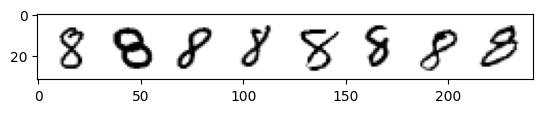

In [2]:
# Loading the dataset
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# Finding indices where the label is 8
indices = [i for i, (_, label) in enumerate(dataset) if label == 8]

# Creating a subset of the dataset using only those indices
subset_8 = Subset(dataset, indices)

# Creating the DataLoader using the subset
train_dataloader = DataLoader(subset_8, batch_size=8, shuffle=True)

# Showing some examples
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Creating a Unet model

In [3]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        # Self.model is an unconditional UNet
        self.model = UNet2DModel(
            sample_size=28,  # the target image resolution
            in_channels=1,
            out_channels=1,
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )


    def forward(self, x, t):
        bs, ch, w, h = x.shape

        # Feeding this to the UNet alongside the timestep and returning the prediction
        return self.model(x, t).sample  # (bs, 1, 28, 28)

In [4]:
# Creating a noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [5]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(subset_8, batch_size=128, shuffle=True)

n_epochs = 30

net = Unet().to(device)

# loss function
loss_fn = nn.MSELoss()

# optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping record of the losses for later viewing
losses = []

# Training step

In [ ]:
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        x = x.to(device) * 2 - 1  # Data on the GPU (mapped to (-1, 1))

        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Getting the model prediction
        pred = net(noisy_x, timesteps)

        # Calculating the loss
        loss = loss_fn(pred, noise)

        # Backprop and then updating the params
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Storing the loss for plotting
        losses.append(loss.item())

    # Printing out the average of the last 100 loss values to get an idea of our progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.138709


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.089859


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.075895


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.068552


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.064017


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.060730


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.059379


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.058477


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.056929


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.056421


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 10. Average of the last 100 loss values: 0.055182


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 11. Average of the last 100 loss values: 0.055000


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 12. Average of the last 100 loss values: 0.054585


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 13. Average of the last 100 loss values: 0.054075


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 14. Average of the last 100 loss values: 0.053105


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 15. Average of the last 100 loss values: 0.051255


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 16. Average of the last 100 loss values: 0.050758


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 17. Average of the last 100 loss values: 0.050656


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 18. Average of the last 100 loss values: 0.050567


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 19. Average of the last 100 loss values: 0.051034


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 20. Average of the last 100 loss values: 0.050712


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 21. Average of the last 100 loss values: 0.050122


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 22. Average of the last 100 loss values: 0.049817


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 23. Average of the last 100 loss values: 0.049164


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 24. Average of the last 100 loss values: 0.050002


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 25. Average of the last 100 loss values: 0.049878


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 26. Average of the last 100 loss values: 0.049354


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 27. Average of the last 100 loss values: 0.048752


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 28. Average of the last 100 loss values: 0.048945


  0%|          | 0/46 [00:00<?, ?it/s]

Finished epoch 29. Average of the last 100 loss values: 0.049548


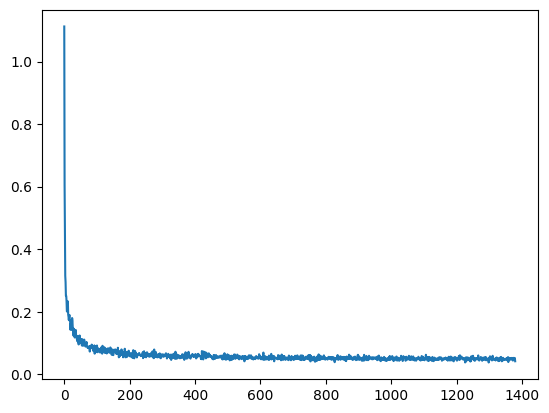

In [ ]:
# Plotting the loss curve
plt.plot(losses)

# Saving the model to load it later when we need it

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'loss': loss,
}, "/content/drive/MyDrive/PIMA/Diffusion/checkpoint.pt")

# Loading the model

In [6]:
checkpoint = torch.load( "/content/drive/MyDrive/PIMA/Diffusion/checkpoint.pt")
net.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

# Testing

0it [00:00, ?it/s]

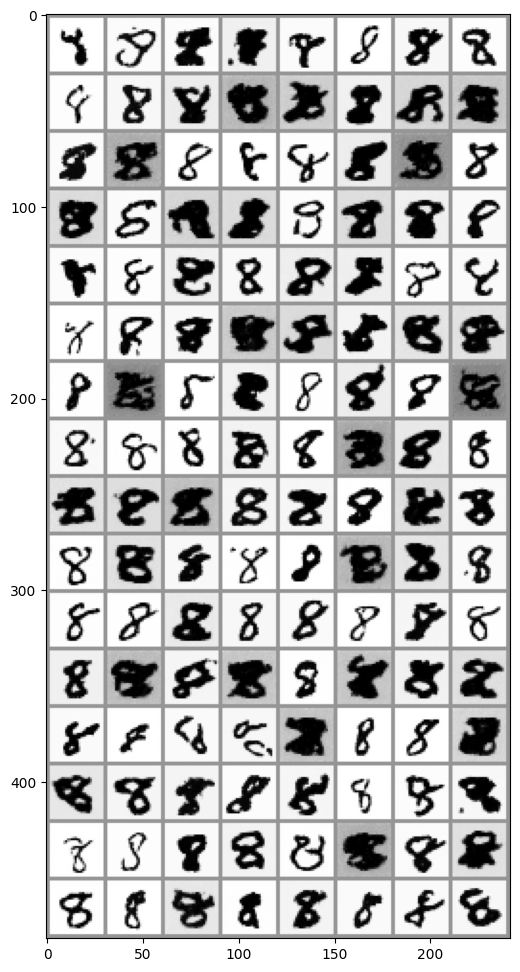

In [7]:
# Preparing random x to start from
x = torch.randn(128, 1, 28, 28).to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Getting the model prediction
    with torch.no_grad():
        residual = net(x, t)

    # Updating the sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Showing the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")

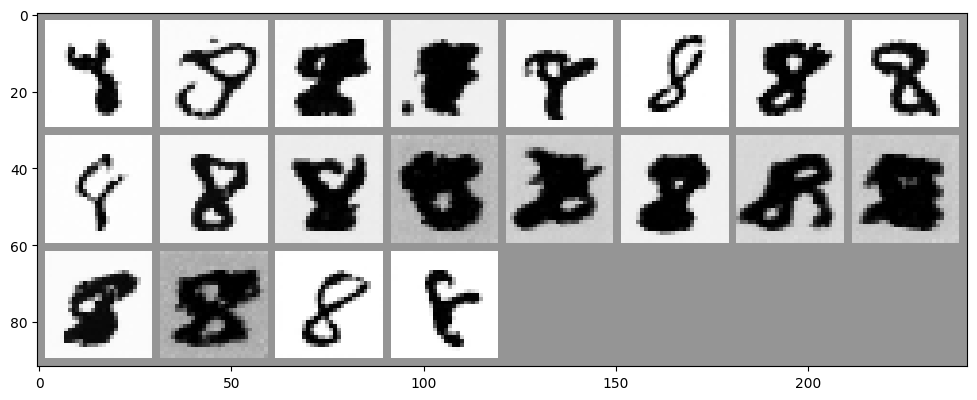

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1)[:20], nrow=8)[0], cmap="Greys")

# Evaluation: Classifier and FID score
## Classifier

In [10]:
# Loading the Classifier model to evaluate
from tensorflow.keras.models import load_model
classifier = load_model("/content/drive/MyDrive/PIMA/Classifier/classifier_model.h5")

In [11]:
# Converting to [0, 1] and moving to CPU numpy array
images_np = ((x.detach().cpu().numpy() + 1) / 2).clip(0, 1)

# Reshaping from (N, 1, 28, 28) to (N, 784)
images_np = images_np.reshape(images_np.shape[0], 784)
images_np = images_np.astype('float32')
print("Input shape:", images_np.shape)

Input shape: (128, 784)


In [12]:
# Predicting
import numpy as np
predictions = classifier.predict(images_np)
predicted_labels = np.argmax(predictions, axis=1)

print("Predicted labels:", predicted_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
Predicted labels: [8 8 8 0 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 5 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 3 8 8 3 8 8 8 8 8 1 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 7 8 5 8 8 8 8 0 8 8 8 8 8]


In [13]:
# Calculating the predicted label's accuracy
N = len(predicted_labels)
true_labels = np.full(N, 8)
accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 89.06%


### Confusion Matrix

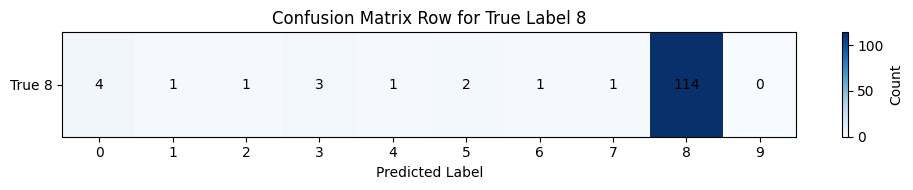

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Computing confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(10))

# Extracting row for true label 8
cm_row_8 = cm[8:9, :]  # shape (1, 10)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))
im = ax.imshow(cm_row_8, cmap="Blues", aspect='auto')

for j in range(10):
    count = cm_row_8[0, j]
    ax.text(j, 0, str(count), ha="center", va="center", color="black")

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticks([0])
ax.set_yticklabels(["True 8"])
ax.set_xlabel("Predicted Label")
ax.set_title("Confusion Matrix Row for True Label 8")

plt.colorbar(im, ax=ax, orientation='vertical', label='Count')
plt.tight_layout()
plt.show()

## FID Score

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity

In [9]:
import torch

from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T
# Initializing the FID metric
fid = FrechetInceptionDistance(feature=64).to(device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 39.1MB/s]


In [10]:
# Adding real images to FID
for x, _ in train_dataloader:

    # Resizing the images to 299x299
    x = torch.nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

    # Converting the images to 3 channels
    x = x.repeat(1, 3, 1, 1)  # (B, 3, 299, 299)

    # Scaling the intensity to [0, 255] and convert to uint8
    x = (x * 255).clamp(0, 255).byte()

    # updating the FID score
    fid.update(x.to(device), real=True)

In [14]:
# Preparing random x to start from
x = torch.randn(128, 1, 28, 28).to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Getting the model prediction
    with torch.no_grad():
        residual = net(x, t)

    # Updating the sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

0it [00:00, ?it/s]

In [15]:
x_fake = x.detach().cpu().clip(-1, 1)  # (N, 1, 28, 28)

# Converting to [0, 1] and to 3-channel 299x299 for FID
x_fake = (x_fake + 1) / 2
x_fake = torch.nn.functional.interpolate(x_fake, size=(299, 299))
x_fake = x_fake.repeat(1, 3, 1, 1)

# Scaling to [0, 255] and convert to uint8
x_fake = (x_fake * 255).clamp(0, 255).byte()

# Adding generated images
fid.update(x_fake.to(device), real=False)

# Computing the FID score
fid_score = fid.compute()
print(f"FID Score: {fid_score.item():.2f}")

FID Score: 7.96
